In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np

from scipy.signal import argrelextrema
from scipy.ndimage import gaussian_filter1d
from moabb.datasets import BI2013a
import matplotlib.pyplot as plt

from preprocessing.data_processing import get_clean_epochs, Lagger
from preprocessing.data_processing_iterative import AltFilters
from preprocessing.power import field_root_mean_square, plot_fmrs, trim_mean_frms

In [3]:
dataset=BI2013a()
epochs = get_clean_epochs(dataset, subjects_list=[1])

/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 480 events (all good), 0 – 1 s (baseline off), ~30.1 MB, data loaded,
 'Target': 80
 'NonTarget': 400>
  warn(f"warnEpochs {epochs}")
/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 480 events (all good), 0 – 1 s (baseline off), ~30.1 MB, data loaded,
 'Target': 80
 'NonTarget': 400>
  warn(f"warnEpochs {epochs}")
/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 480 events (all good), 0 – 1 s (baseline off), ~30.1 MB, data loaded,
 'Target': 80
 'NonTarget': 400>
  warn(f"warnEpochs {epochs}")
/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 480 events (all good), 0 – 1 s (baseline off), ~30.1 MB, data 

Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns


/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 480 events (all good), 0 – 1 s (baseline off), ~30.1 MB, data loaded,
 'Target': 80
 'NonTarget': 400>
  warn(f"warnEpochs {epochs}")
/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 480 events (all good), 0 – 1 s (baseline off), ~30.1 MB, data loaded,
 'Target': 80
 'NonTarget': 400>
  warn(f"warnEpochs {epochs}")
/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 480 events (all good), 0 – 1 s (baseline off), ~30.1 MB, data loaded,
 'Target': 80
 'NonTarget': 400>
  warn(f"warnEpochs {epochs}")
/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/paradigms/base.py:350: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be

Adding metadata with 3 columns
3360 matching events found
No baseline correction applied
Dataset median value:  -2.277286300659693e-07
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F5', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F5', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F5', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F5', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F5', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F5', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F5', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejec

Spatial and Temporal Filters converged.
Plots target and non target


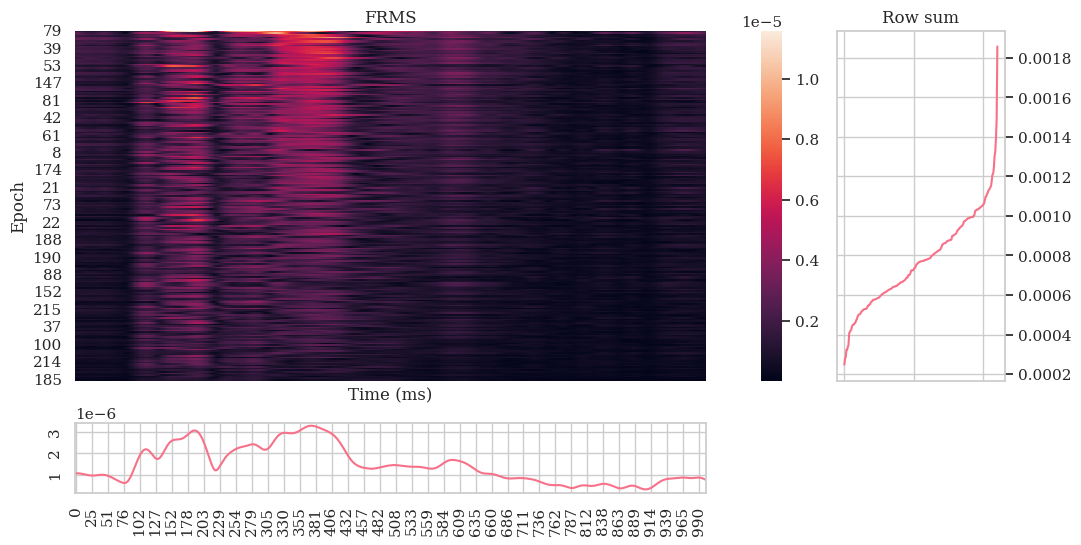

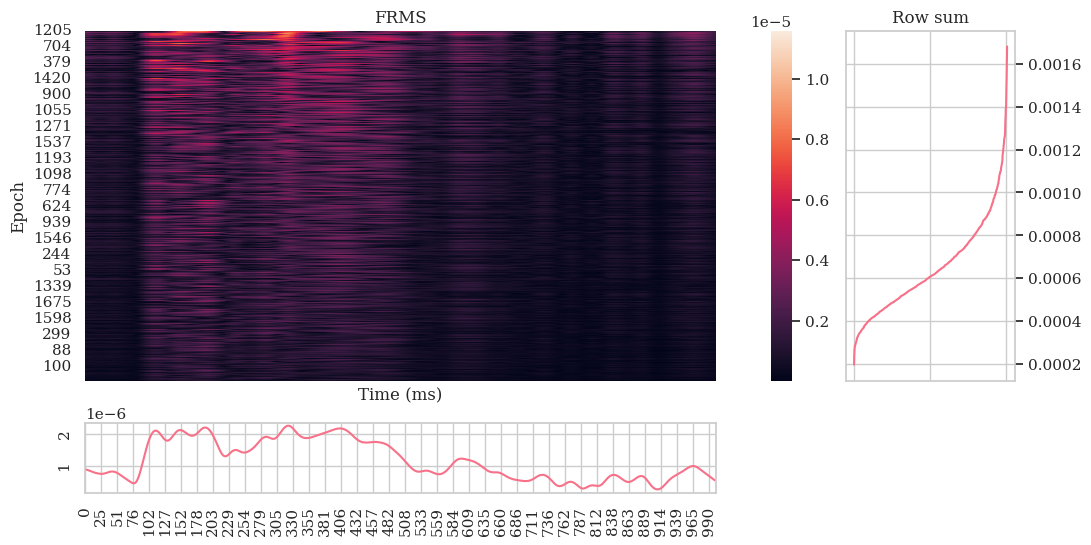

In [25]:
alt_filter = AltFilters(epochs, p=4)
filtered_epochs, _ = alt_filter.fit_and_apply(class_="Target", plot_it=False)

print("Plots target and non target")
frms_tg = field_root_mean_square(filtered_epochs["Target"])
plot_fmrs(frms_tg)

filtered_epochs_non_target = alt_filter.apply(epochs["NonTarget"])
frms_ntg = field_root_mean_square(filtered_epochs_non_target)
plot_fmrs(frms_ntg, heat_min=np.min(frms_tg.values), heat_max=np.max(frms_tg.values))

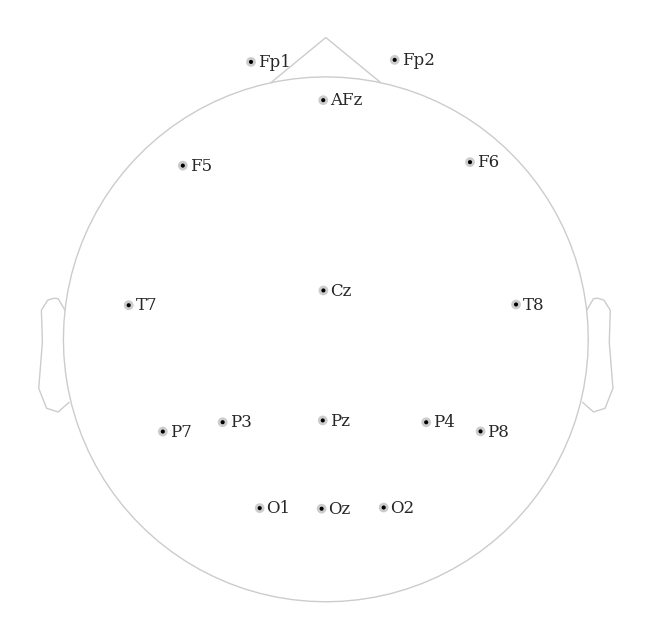

In [5]:
#show channel locations
filtered_epochs.plot_sensors(show_names=True);

In [6]:
def peaks_frms(mean_frms, times, t_interval = 70, thr_per = 0.25, plot = True, smooth = True):

    """
    Get peaks times of mean FRMS and its smoothed version
    Params:
        t_interval: time interval in which samples should be Gaussian-smoothed in ms
        thr_per: threshold percentage of valuable peaks. Only peaks above thr_per*max of smoothed mean FRMS are acceptable
        plot: True if visualization desired
    returns:
        valid_idx: peaks idx 
        smoothed_mean_frms: smoothed mean FRMS
    """

    #get number of samples corresponding to ~t_interval ms
    sfreq = epochs.info['sfreq'] #sampling frequency
    ns = int(t_interval*1e-3*sfreq) #around t_interval as number of samples
    if smooth:
        smoothed_mean_frms = gaussian_filter1d(mean_frms, sigma=ns/6)
    else:
        smoothed_mean_frms = mean_frms
    max_idx = argrelextrema(smoothed_mean_frms, np.greater)
    #  local max >= percentage threshold of maxmean_frms
    valid_idx = np.where(smoothed_mean_frms>=thr_per*np.max(smoothed_mean_frms))[0]
    #get valid local extrema idx
    valid_idx = valid_idx[np.isin(valid_idx, max_idx)]
    if plot:
        plt.figure(figsize=(12,4))
        plt.plot(times, mean_frms, label="filtered mean FRMS")
        if smooth:
            plt.plot(times, smoothed_mean_frms, linestyle = "dashed", color = "b", label="smoothed filtered mean FRMS")
        plt.scatter(times[max_idx], smoothed_mean_frms[max_idx], color = "b", label="local max of (smoothed) filtered mean FRMS ")
        plt.scatter(times[valid_idx], smoothed_mean_frms[valid_idx], color = "g", label = "local max >= {} max of (smoothed) filtered mean FRMS".format(thr_per))
        plt.xlabel("ms")
        plt.ylabel("V")
        plt.legend()
    return times[valid_idx], smoothed_mean_frms

## Filtered

### Target Smoothed

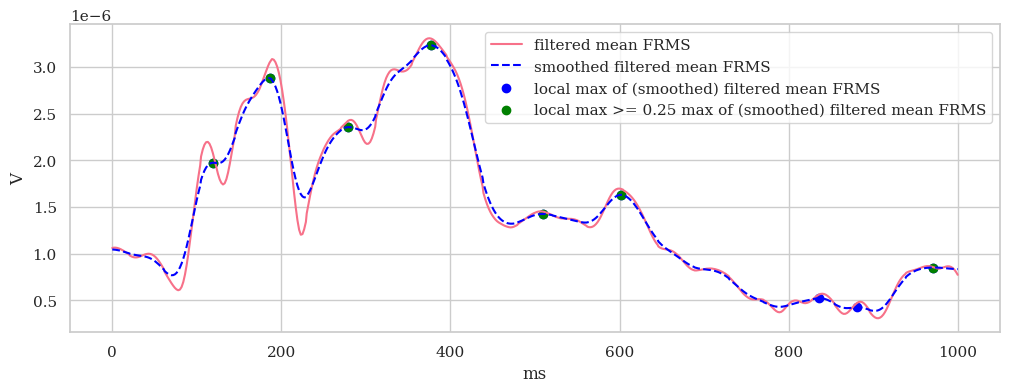

In [26]:
#Average filtered target FRMS 
cols_mean, times = trim_mean_frms(frms_tg)
peaks_times, smoothed_cols_mean = peaks_frms(cols_mean, times)

Need more than one channel to make topography for eeg. Disabling interactivity.


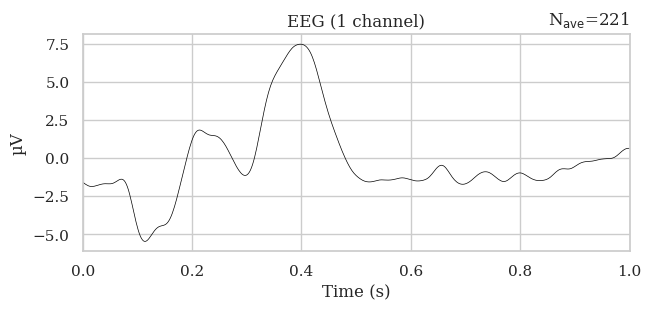

In [38]:
filtered_epochs["Target"].average(picks=["Cz"]).plot();

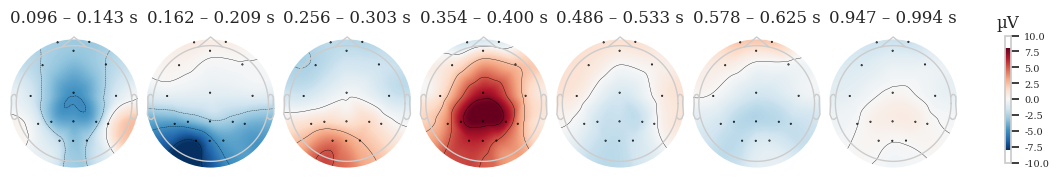

In [9]:
#Average filtered target evoked pot
#averages of 50 ms bins centered on these time points to reduce the noise in the topographies
filtered_epochs["Target"].average().plot_topomap(times= peaks_times/1e3, ch_type="eeg", average=0.05);

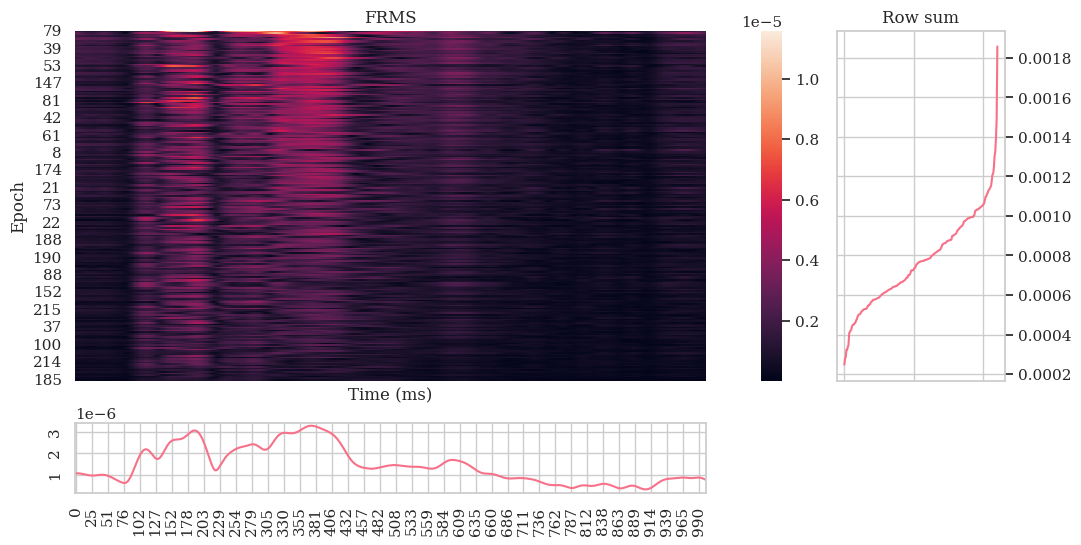

In [10]:
#filtered target FRMS 

plot_fmrs(frms_tg)

### Non-Target Smoothed

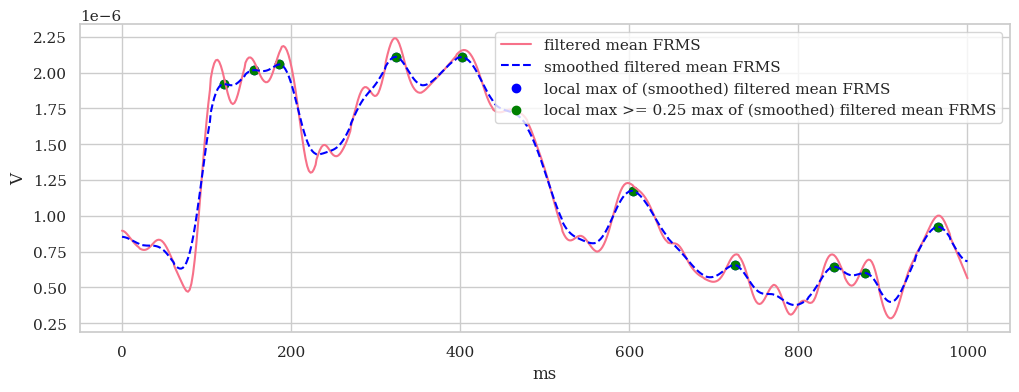

In [27]:
#Average filtered non-target FRMS 
cols_mean_ntg, times = trim_mean_frms(frms_ntg)
peaks_times, smoothed_cols_mean_ntg = peaks_frms(cols_mean_ntg, times)


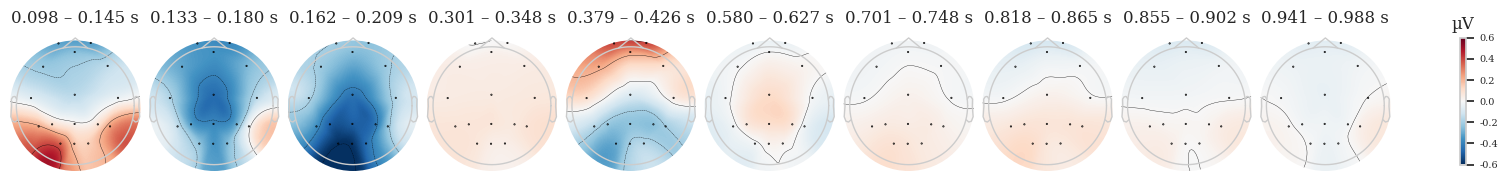

In [12]:
#Average filtered non-target evoked pot
#averages of 50 ms bins centered on these time points to reduce the noise in the topographies
filtered_epochs["NonTarget"].average().plot_topomap(times= peaks_times/1e3, ch_type="eeg", average=0.05);

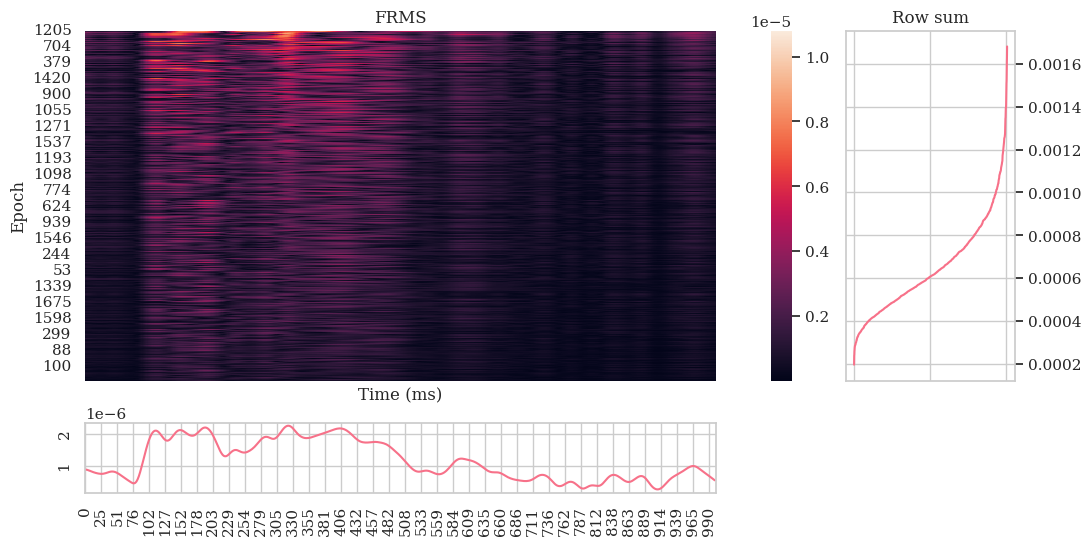

In [13]:
#Average filtered non-target FRMS 

plot_fmrs(frms_ntg)

### Target Smoothed - Non-Target Smoothed

Text(0, 0.5, 'V')

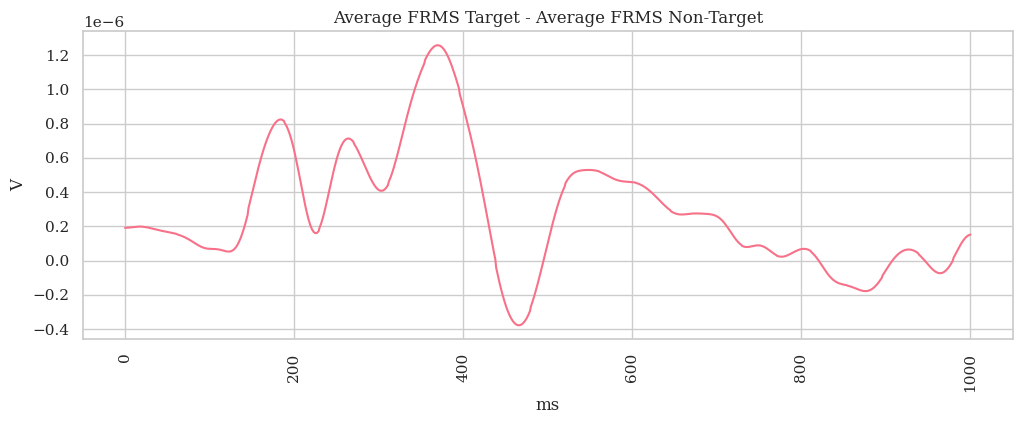

In [34]:
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(times, smoothed_cols_mean - smoothed_cols_mean_ntg)
ax1.tick_params(axis = 'x', which='major', labelrotation=90)
ax1.set_title("Average FRMS Target - Average FRMS Non-Target")
ax1.set_xlabel("ms")
ax1.set_ylabel("V")


## Filtered + Lag-corrected

### Target Smoothed

Iteration num:  0


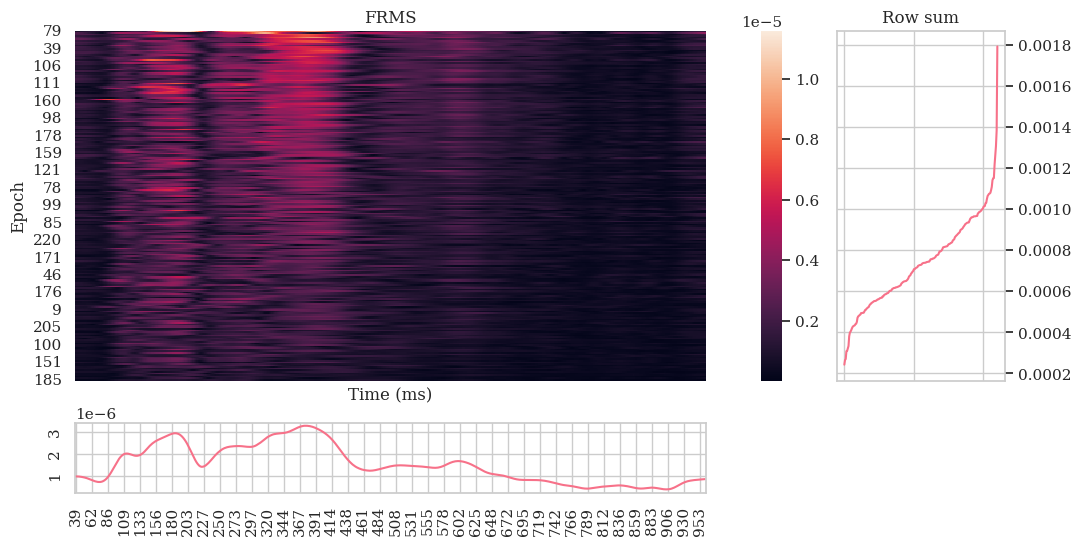

In [35]:
#Average filtered and lag-corrected target FRMS 

lagger = Lagger(filtered_epochs["Target"])
lag_corrected_epochs = lagger.compute_and_correct_lags()
frms_tg = field_root_mean_square(lag_corrected_epochs)
plot_fmrs(frms_tg)

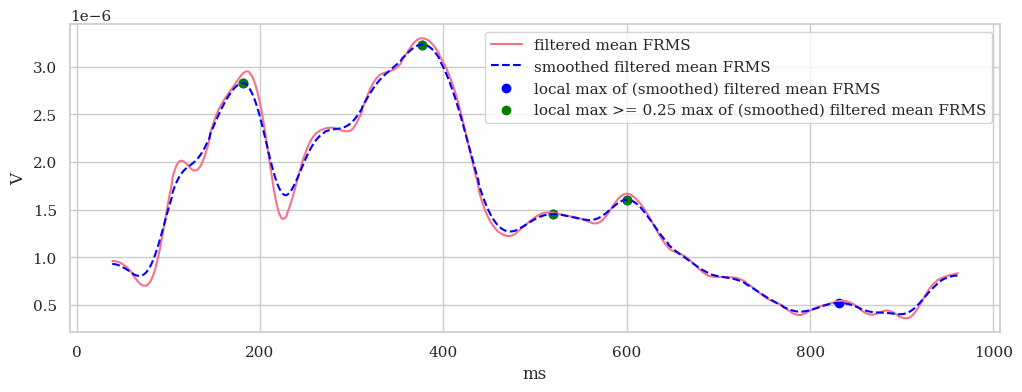

In [36]:
#Average filtered and lag-corrected target FRMS  (smoothed)

cols_mean, times = trim_mean_frms(frms_tg)
peaks_times, smoothed_cols_mean = peaks_frms(cols_mean, times)

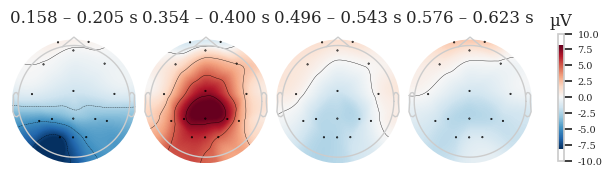

In [16]:
#Average filtered and lag-corrected target evoked pot (smoothed)
#averages of 50 ms bins centered on these time points to reduce the noise in the topographies
lag_corrected_epochs.average().plot_topomap(times= peaks_times/1e3, ch_type="eeg", average=0.05);

### Target Non-Smoothed

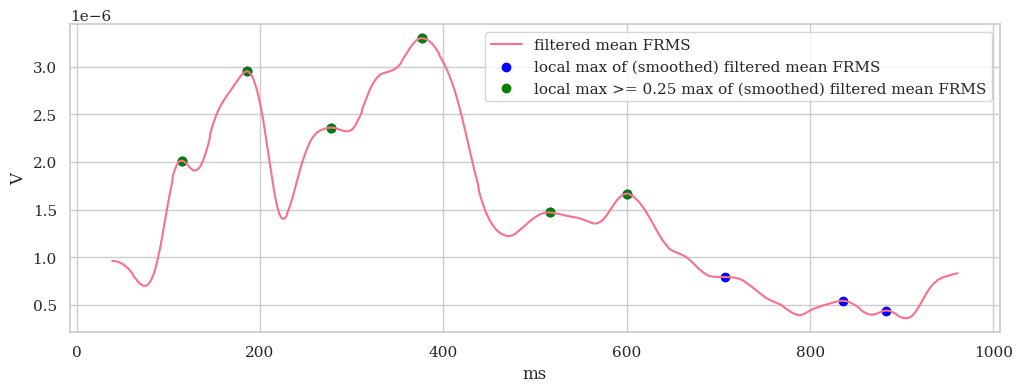

In [17]:
#Average filtered and lag-corrected target FRMS  (non-smoothed)

cols_mean, times = trim_mean_frms(frms_tg)
peaks_times, smoothed_cols_mean = peaks_frms(cols_mean, times, smooth=False)

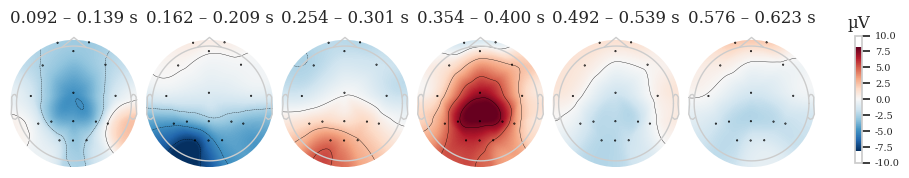

In [18]:
#Average filtered and lag-corrected target evoked pot (non-smoothed)
#averages of 50 ms bins centered on these time points to reduce the noise in the topographies
lag_corrected_epochs.average().plot_topomap(times= peaks_times/1e3, ch_type="eeg", average=0.05);

### Non-Target Smoothed

In [19]:
#Average filtered and lag-corrected non-target FRMS 

lagger = Lagger(filtered_epochs["NonTarget"])
lag_corrected_epochs_ntg = lagger.compute_and_correct_lags()
frms_ntg = field_root_mean_square(lag_corrected_epochs_ntg)


Iteration num:  0


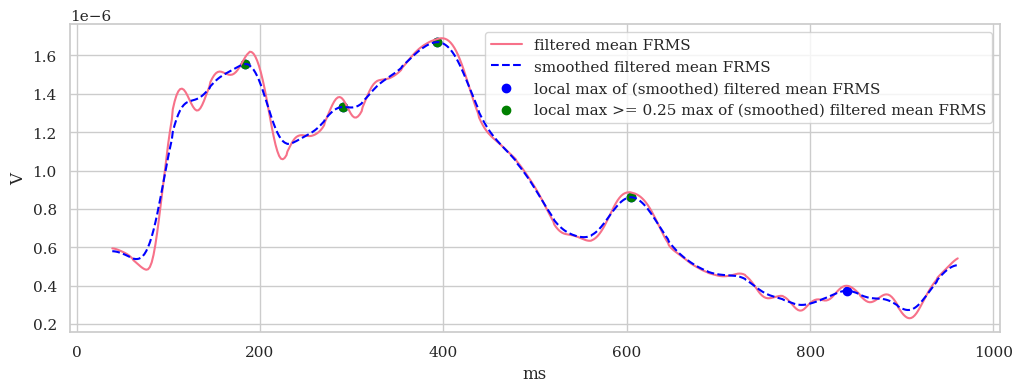

In [20]:
#Average filtered and lag-corrected non-target FRMS  (smoothed)

cols_mean_ntg, times = trim_mean_frms(frms_ntg)
peaks_times, smoothed_cols_mean_ntg = peaks_frms(cols_mean_ntg, times)

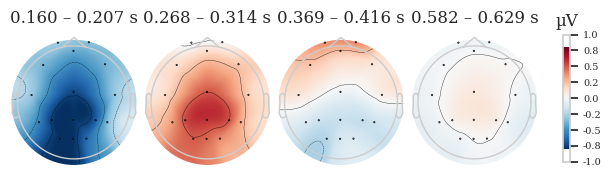

In [21]:
#Average filtered and lag-corrected non-target evoked pot (smoothed)
#averages of 50 ms bins centered on these time points to reduce the noise in the topographies
lag_corrected_epochs_ntg.average().plot_topomap(times= peaks_times/1e3, ch_type="eeg", average=0.05);

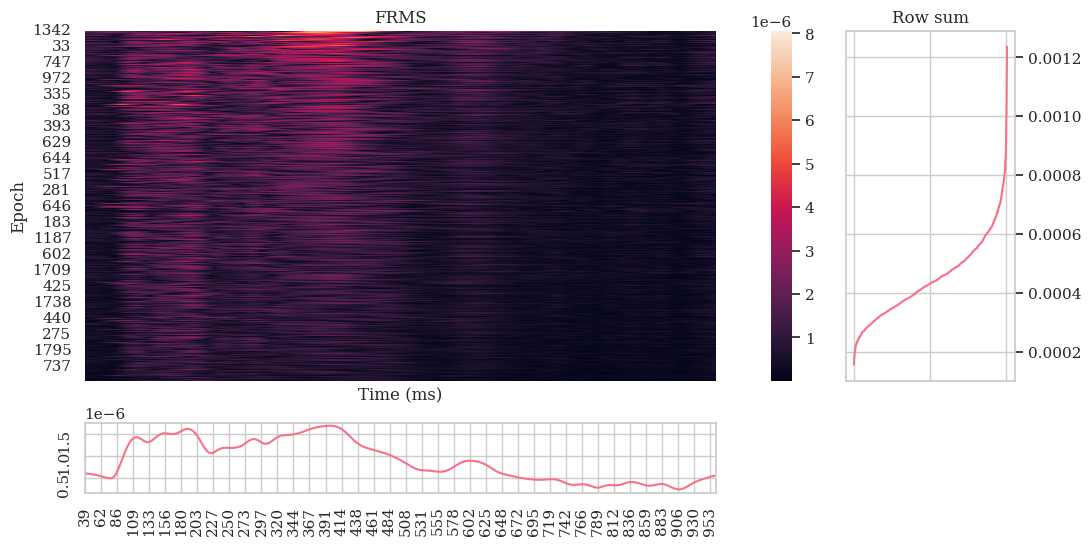

In [22]:
plot_fmrs(frms_ntg)

### Non-Target Non-Smoothed

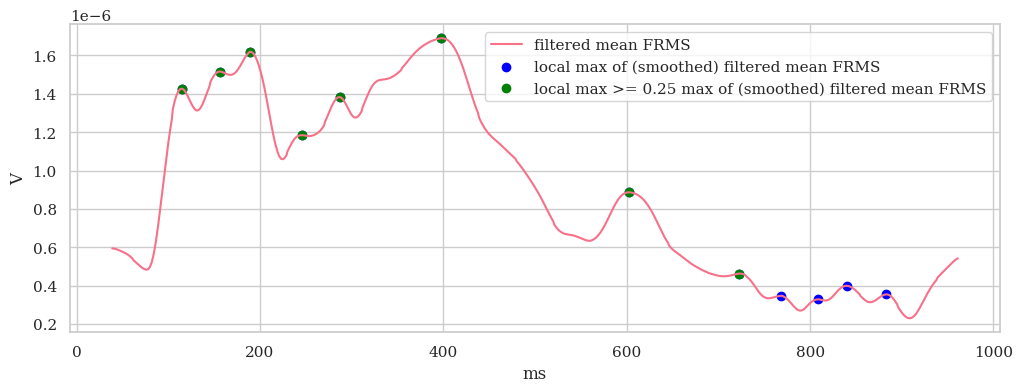

In [23]:
#Average filtered and lag-corrected non-target FRMS  (non-smoothed)

cols_mean_ntg, times = trim_mean_frms(frms_ntg)
peaks_times, smoothed_cols_mean_ntg = peaks_frms(cols_mean_ntg, times, smooth=False)

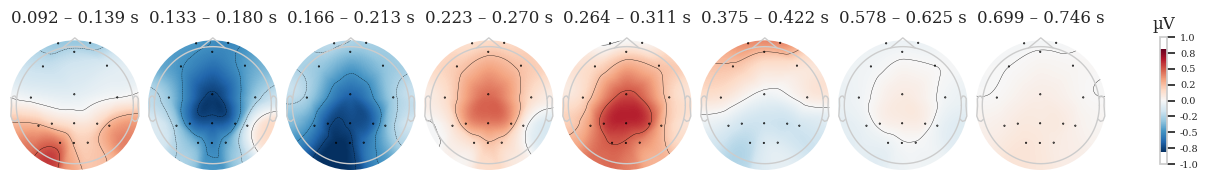

In [24]:
#Average filtered and lag-corrected non-target evoked pot (non-smoothed)
#averages of 50 ms bins centered on these time points to reduce the noise in the topographies
lag_corrected_epochs_ntg.average().plot_topomap(times= peaks_times/1e3, ch_type="eeg", average=0.05);